# Multi-class Refactoring Recommendation with SMOTE and Tree-based Algorithms
by Jerelyn Co (Jan 2018)

Main Reference: Kumar, L., & Sureka, A. (2017). Application of LSSVM and SMOTE on Seven Open Source Projects for Predicting Refactoring at Class Level. Asia-Pacific Software Engineering Conference (APSEC 2017), 90–99. https://doi.org/10.1109/APSEC.2017.15

In [111]:
import os

import numpy as np
import pandas as pd

import xgboost as xgb

import seaborn as sn
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold,train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score, classification_report, confusion_matrix, accuracy_score


%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

Populating the interactive namespace from numpy and matplotlib


/home/jerelyn/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['indices', 'f', 'std', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Consolidating and transforming datasets

In [112]:
data_dir = "data/refactdatasets/RefactDataSetValidated/"

In [113]:
data_df = pd.DataFrame()
for proj in os.listdir(data_dir):
    proj_name = proj
    commit = os.listdir(data_dir+proj)[0]
    df = pd.read_csv(data_dir+proj+"/"+commit+"/"+proj_name+"-Class.csv")
    df["proj_name"] = proj_name
    data_df = data_df.append(df)

In [114]:
proj_names = data_df["proj_name"].unique()
metrics = ["CC","CCL","CCO","CI","CLC","CLLC","LDC","LLDC","LCOM5","NL","NLE","WMC","CBO","CBOI","NII","NOI","RFC","AD","CD","CLOC","DLOC","PDA","PUA","TCD","TCLOC","DIT","NOA","NOC","NOD","NOP","LLOC","LOC","NA","NG","NLA","NLG","NLM","NLPA","NLPM","NLS","NM","NOS","NPA","NPM","NS","TLLOC","TLOC","TNA","TNG","TNLA","TNLG","TNLM","TNLPA","TNLPM","TNLS","TNM","TNOS","TNPA","TNPM","TNS","WarningBlocker","WarningCritical","WarningInfo","WarningMajor","WarningMinor","Android Rules","Basic Rules","Brace Rules","Clone Implementation Rules","Clone Metric Rules","Code Size Rules","Cohesion Metric Rules","Comment Rules","Complexity Metric Rules","Controversial Rules","Coupling Metric Rules","Coupling Rules","Design Rules","Documentation Metric Rules","Empty Code Rules","Finalizer Rules","Import Statement Rules","Inheritance Metric Rules","J2EE Rules","JUnit Rules","Jakarta Commons Logging Rules","Java Logging Rules","JavaBean Rules","MigratingToJUnit4 Rules","Migration Rules","Migration13 Rules","Migration14 Rules","Migration15 Rules","Naming Rules","Optimization Rules","Security Code Guideline Rules","Size Metric Rules","Strict Exception Rules","String and StringBuffer Rules","Type Resolution Rules","Unnecessary and Unused Code Rules","Vulnerability Rules"]
refact_classes = ["REMOVE_PARAMETER","ADD_PARAMETER","REPLACE_MAGIC_NUMBER_WITH_CONSTANT","REMOVE_ASSIGNMENT_TO_PARAMETERS","INTRODUCE_EXPLAINING_VARIABLE","INLINE_TEMP","REMOVE_CONTROL_FLAG","CONSOLIDATE_COND_EXPRESSION","CONSOLIDATE_DUPLICATE_COND_FRAGMENTS","REPLACE_NESTED_COND_WITH_GUARD_CLAUSES","INLINE_METHOD","EXTRACT_METHOD","REPLACE_EXCEPTION_WITH_TEST","INTRODUCE_ASSERTION","RENAME_METHOD","REPLACE_METHOD_WITH_METHOD_OBJECT","MOVE_METHOD","HIDE_METHOD","INTRODUCE_NULL_OBJECT","INTRODUCE_LOCAL_EXTENSION","EXTRACT_SUPERCLASS","EXTRACT_INTERFACE","MOVE_FIELD"]

Transforming class frequency columns into one column

In [115]:
data_df = data_df[metrics+refact_classes+["proj_name","Refact_Sum"]]
data_df_csf = pd.DataFrame()
df = pd.DataFrame()
for cls in refact_classes:
    df = pd.DataFrame(np.repeat(data_df[["proj_name"] + metrics].values, data_df[cls].values, axis=0), columns=["proj_name"] + metrics)
    df["refact_class"] = cls 
    df["w_ref"] = 1
    data_df_csf = data_df_csf.append(df)

data_df_wo_ref = data_df[data_df["Refact_Sum"]==0][["proj_name"]+metrics]
data_df_wo_ref["refact_class"] = "NONE"
data_df_wo_ref["w_ref"] = 0
data_df_csf = data_df_csf.append(data_df_wo_ref)
data_df_csf.head()

,proj_name,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,...,Optimization Rules,Security Code Guideline Rules,Size Metric Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,refact_class,w_ref
0,mct,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,REMOVE_PARAMETER,1
1,mct,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,REMOVE_PARAMETER,1
2,mct,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,REMOVE_PARAMETER,1
3,mct,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,REMOVE_PARAMETER,1
4,oryx,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,REMOVE_PARAMETER,1


## Analyzing class distribution

In [116]:
data_df_csf["refact_class"].value_counts()

NONE                                  5934
ADD_PARAMETER                           36
REMOVE_PARAMETER                        27
INTRODUCE_EXPLAINING_VARIABLE           17
REPLACE_METHOD_WITH_METHOD_OBJECT       17
MOVE_METHOD                             12
INTRODUCE_ASSERTION                     10
EXTRACT_METHOD                          10
RENAME_METHOD                            9
INLINE_TEMP                              7
EXTRACT_INTERFACE                        2
INLINE_METHOD                            2
REPLACE_MAGIC_NUMBER_WITH_CONSTANT       1
REMOVE_ASSIGNMENT_TO_PARAMETERS          1
Name: refact_class, dtype: int64

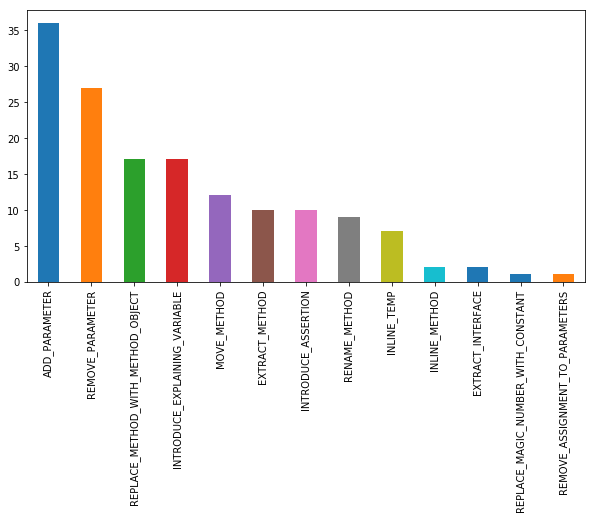

In [117]:
data_df_csf[data_df_csf["refact_class"]!="NONE"]["refact_class"].value_counts().plot(kind='bar')

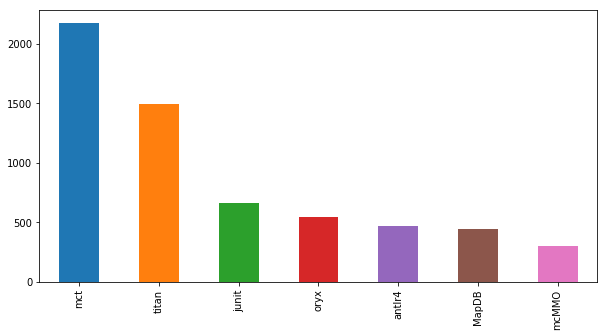

In [118]:
data_df_csf[data_df_csf["refact_class"]!="None"]["proj_name"].value_counts().plot(kind='bar')

Due to the number of samples, we'll be forced to only consider the top 7 refactoring methods. 

In [119]:
refact_classes = data_df_csf["refact_class"].value_counts().index[:8]
data_df_csf = data_df_csf[data_df_csf["refact_class"].isin(refact_classes)]

In [120]:
data_df_csf["refact_class"].value_counts()

NONE                                 5934
ADD_PARAMETER                          36
REMOVE_PARAMETER                       27
INTRODUCE_EXPLAINING_VARIABLE          17
REPLACE_METHOD_WITH_METHOD_OBJECT      17
MOVE_METHOD                            12
INTRODUCE_ASSERTION                    10
EXTRACT_METHOD                         10
Name: refact_class, dtype: int64

For multi-class classification, those 8 are what we are going to use.

## Preprocessing before Classification

In [121]:
def get_inputs(data, metrics, binary_csf=True):
    if binary_csf:
        raw_X, y = data[metrics], data["w_ref"]
    else:
        # Label encoding for refactoring types. Transforming categorical labels to 0 to n_classes - 1.
        le = preprocessing.LabelEncoder()
        le.fit(data_df_csf["refact_class"])
        data["refact_class"] = le.transform(data["refact_class"])
        raw_X, y = data[metrics], data["refact_class"]
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(raw_X)
    return X, y

In [122]:
TEST_SIZE = 0.3
RAND_STATE = 12

In [123]:
def metrics_report(n_mod, mod_type, true, pred):
    print('Model {} {} Report:'.format(n_mod, mod_type))
    print(classification_report(true, pred))

    print("Accuracy {} {} Report:".format(n_mod, mod_type))
    print(accuracy_score(true, pred) * 100)
    print("-----\n")


## Binary Classification

### Using Random Forest

In [124]:
X, y = get_inputs(data_df_csf, metrics)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

In [127]:
%%time
tuned_parameters = [{'n_estimators': [10, 20, 50, 100]}]

clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
clf_rf.fit(X_train, y_train)

print("Best parameters set found on development set: {}".format(clf_rf.best_params_))
print("Grid scores on development set:")
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = y_test, clf_rf.predict(X_test)
metrics_report(1, "RF", y_test, y_pred)

Best parameters set found on development set: {'n_estimators': 50}
Grid scores on development set:
0.989 (+/-0.004) for {'n_estimators': 10}
0.989 (+/-0.003) for {'n_estimators': 20}
0.990 (+/-0.003) for {'n_estimators': 50}
0.990 (+/-0.003) for {'n_estimators': 100}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Model 1 RF Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1776
          1       1.00      0.56      0.72        43

avg / total       0.99      0.99      0.99      1819

Accuracy 1 RF Report:
98.9554700385
-----

CPU times: user 4.6 s, sys: 8 ms, total: 4.61 s
Wall time: 4.61 s


### Using XGBoost

[Kaggle Introduction](https://www.kaggle.com/babatee/intro-xgboost-classification)

In [128]:
%%time
model1 = xgb.XGBClassifier()
train_model1 = model1.fit(X_train, y_train)

pred1 = train_model1.predict(X_test)

metrics_report(1, "XGBoost", y_test, pred1)

Model 1 XGBoost Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1776
          1       1.00      0.23      0.38        43

avg / total       0.98      0.98      0.98      1819

Accuracy 1 XGBoost Report:
98.1858163826
-----

CPU times: user 800 ms, sys: 4 ms, total: 804 ms
Wall time: 842 ms


In [129]:
%%time
model3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
train_model3 = model3.fit(X_train, y_train)
pred3 = train_model3.predict(X_test)

metrics_report(3, "XGBoost", y_test, pred3)

Model 3 XGBoost Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1776
          1       1.00      0.58      0.74        43

avg / total       0.99      0.99      0.99      1819

Accuracy 3 XGBoost Report:
99.0104452996
-----

CPU times: user 17.1 s, sys: 24 ms, total: 17.1 s
Wall time: 4.53 s


In [ ]:
%%time
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
train_model4 = gsearch1.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)
metrics_report(5, "XGBoost", y_test, pred4)

In [110]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

train_model5 = gsearch2b.fit(X_train, y_train)
pred5 = train_model5.predict(X_test)

metrics_report(5, "XGBoost", y_test, pred5)

KeyboardInterrupt: 

### Applying SMOTE to dataset. 
As we have seen during our data exploration, the dataset is severely imbalanced.

Reference: [Becker](https://www.google.co.jp/search?client=ubuntu&channel=fs&q=ROC+auc+curve+in+python&ie=utf-8&oe=utf-8&gfe_rd=cr&dcr=0&ei=EE1UWuPXNcyQ8QfT1YbAAw)

In [36]:
from collections import Counter
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

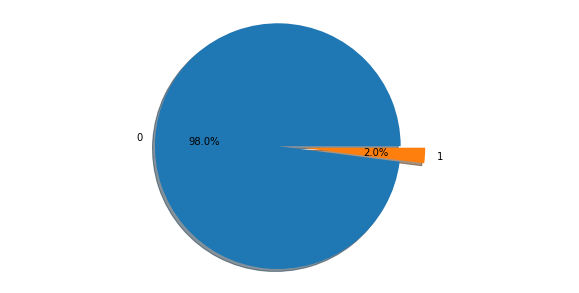

In [37]:
plot_pie(y_train)

In [51]:
sm = SMOTE(random_state=12, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


After SMOTE, we should see equal class distribution from synthetic samples generation.

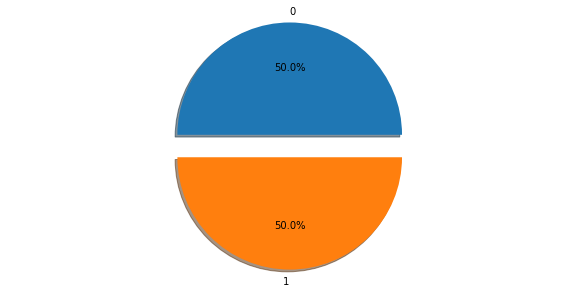

In [49]:
plot_pie(y_train_res)

Let's try again

In [52]:
scores = ['precision', 'recall']
tuned_parameters = [{'n_estimators': [10, 20, 50, 100]}]

clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
clf_rf.fit(X_train_res, y_train_res)

print("Best parameters set found on development set: {}".format(clf_rf.best_params_))
print("Grid scores on development set:")
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = y_test, clf_rf.predict(X_test)
metrics_report(2, "RF", y_test, y_pred)

Best parameters set found on development set: {'n_estimators': 50}
Grid scores on development set:
0.994 (+/-0.010) for {'n_estimators': 10}
0.996 (+/-0.009) for {'n_estimators': 20}
0.997 (+/-0.008) for {'n_estimators': 50}
0.996 (+/-0.008) for {'n_estimators': 100}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Model 2 RF Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1776
          1       0.93      0.58      0.71        43

avg / total       0.99      0.99      0.99      1819

Accuracy 2 RF Report:
98.9004947774
-----



Let's try to reduce features by using the RF's built-in feature importances

Feature ranking:
1. feature RFC (0.054804)
2. feature TNLM (0.040856)
3. feature NLM (0.039006)
4. feature TLLOC (0.036996)
5. feature TNLPA (0.032058)
6. feature CBOI (0.031287)
7. feature CLOC (0.029740)
8. feature TLOC (0.028284)
9. feature TNLA (0.027804)
10. feature LLOC (0.027769)
11. feature NLPA (0.026987)
12. feature LOC (0.025440)
13. feature NOI (0.024349)
14. feature TCLOC (0.023869)
15. feature Size Metric Rules (0.023747)
16. feature WMC (0.021985)
17. feature TNLPM (0.020890)
18. feature TNPM (0.020564)
19. feature NLPM (0.019610)
20. feature CD (0.016998)
21. feature NII (0.016757)
22. feature Naming Rules (0.015086)
23. feature CBO (0.014277)
24. feature NM (0.013543)
25. feature TNPA (0.013350)
26. feature Documentation Metric Rules (0.013284)
27. feature Design Rules (0.013215)
28. feature TNM (0.012422)
29. feature Cohesion Metric Rules (0.012107)
30. feature NOD (0.011262)
31. feature TCD (0.011025)
32. feature TNOS (0.010943)
33. feature JUnit Rules (0.010254)
34.

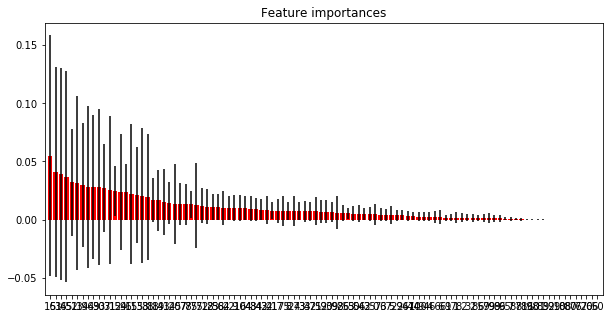

In [53]:
importances = clf_rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, metrics[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [54]:
top_features = []
for i in indices[:30]:
    top_features.append(metrics[i])

Attempting feature reduction

In [55]:
X, y = get_inputs(data_df_csf, top_features)
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [56]:
tuned_parameters = [{'n_estimators': [10, 20, 50, 100]}]

clf_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters, cv=5)
clf_rf.fit(X_train, y_train)

print("Best parameters set found on development set: {}".format(clf_rf.best_params_))
print("Grid scores on development set:")
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = y_test, clf_rf.predict(X_test)
metrics_report(3, "RF", y_test, y_pred)

Best parameters set found on development set: {'n_estimators': 100}
Grid scores on development set:
0.988 (+/-0.002) for {'n_estimators': 10}
0.989 (+/-0.004) for {'n_estimators': 20}
0.989 (+/-0.003) for {'n_estimators': 50}
0.989 (+/-0.003) for {'n_estimators': 100}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Model 3 RF Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1776
          1       0.96      0.58      0.72        43

avg / total       0.99      0.99      0.99      1819

Accuracy 3 RF Report:
98.9554700385
-----



## Multi-class Classification

In [101]:
data_df_csf["refact_class"].value_counts()

5    5934
0      36
6      27
7      17
3      17
4      12
2      10
1      10
Name: refact_class, dtype: int64

In [62]:
X, y = get_inputs(data_df_csf, metrics, binary_csf=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

## Random Forest

### Without SMOTE

In [65]:
tuned_parameters = [{'n_estimators': [10, 20, 50, 100]}]

clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
clf_rf.fit(X_train, y_train)

print("Best parameters set found on development set: {}".format(clf_rf.best_params_))
print("Grid scores on development set:")
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = y_test, clf_rf.predict(X_test)
metrics_report(4, "RF", y_true, y_pred)

/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters set found on development set: {'n_estimators': 50}
Grid scores on development set:
0.988 (+/-0.005) for {'n_estimators': 10}
0.988 (+/-0.005) for {'n_estimators': 20}
0.989 (+/-0.005) for {'n_estimators': 50}
0.989 (+/-0.005) for {'n_estimators': 100}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Model 4 RF Report:
             precision    recall  f1-score   support

          0       0.70      0.64      0.67        11
          1       1.00      0.67      0.80         3
          2       0.00      0.00      0.00         6
          3       1.00      0.33      0.50         6
          4       1.00      1.00      1.00         2
          5       0.99      1.00      0.99      1776
          6       0.86      0.67      0.75         9
          7       1.00      0.33      0.50         6

avg / total       0.98      0.99      0.98      1819

Accuracy 4 RF Report:
98.7905442551
-----



/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RF is throwing warnings on the under-represented classes.. Not surprising.

### With SMOTE

In [102]:
sm = SMOTE(random_state=12, ratio=1.0, k_neighbors=3)
X_train_res, y_train_res = sm.fit_sample(np.asarray(X_train), np.asarray(y_train))

/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [103]:
tuned_parameters = [{'n_estimators': [10, 20, 50, 100]}]

clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
clf_rf.fit(X_train_res, y_train_res)

print("Best parameters set found on development set: {}".format(clf_rf.best_params_))
print("Grid scores on development set:")
means = clf_rf.cv_results_['mean_test_score']
stds = clf_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = y_test, clf_rf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set: {'n_estimators': 20}
Grid scores on development set:
0.991 (+/-0.004) for {'n_estimators': 10}
0.992 (+/-0.004) for {'n_estimators': 20}
0.992 (+/-0.004) for {'n_estimators': 50}
0.992 (+/-0.004) for {'n_estimators': 100}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.70      0.64      0.67        11
          1       1.00      0.67      0.80         3
          2       0.00      0.00      0.00         6
          3       1.00      0.33      0.50         6
          4       1.00      1.00      1.00         2
          5       0.99      1.00      0.99      1776
          6       0.86      0.67      0.75         9
          7       1.00      0.33      0.50         6

avg / total       0.98      0.99      0.98      1819



/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Low scores at refactoring type 2... Hmm. I wonder why.

Feature ranking:
1. feature LCOM5 (0.034333)
2. feature JUnit Rules (0.027441)
3. feature WarningMinor (0.027303)
4. feature Coupling Metric Rules (0.026668)
5. feature Documentation Metric Rules (0.026470)
6. feature NG (0.022205)
7. feature AD (0.020732)
8. feature Design Rules (0.020552)
9. feature LLOC (0.020504)
10. feature TNPM (0.020040)
11. feature NII (0.019436)
12. feature PUA (0.019194)
13. feature CD (0.018275)
14. feature DIT (0.018072)
15. feature CBO (0.017878)
16. feature NS (0.017781)
17. feature NM (0.017243)
18. feature TNG (0.016911)
19. feature NA (0.016829)
20. feature NPM (0.016226)
21. feature NLS (0.016018)
22. feature TLLOC (0.015509)
23. feature WarningInfo (0.015094)
24. feature WarningCritical (0.015068)
25. feature NOI (0.014559)
26. feature NOA (0.014404)
27. feature TNLA (0.014380)
28. feature Empty Code Rules (0.013834)
29. feature CBOI (0.013768)
30. feature NLPM (0.013610)
31. feature TNM (0.013488)
32. feature TCD (0.013413)
33. feature Unnecessary a

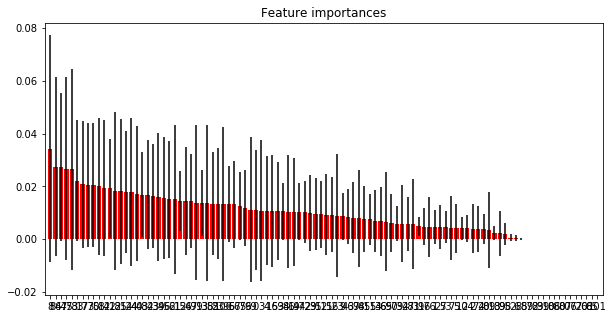

In [105]:
importances = clf_rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, metrics[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(conf_mat, range(8), range(8))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

Hahahaha why did I even try. :(

## What was done
- Multi-class prediction

## Preliminary Findings

- Despite the innate capability of tree-based algorithms to somehow compensate for unbalanced datasets, resampling has to be done in this specific application because of the severely unbalanced dataset. If we don't, then training would be problematic as there will be some classes that may be severely under-represented / zero.

## What else can be done

- Try out binary classification
- Hyperparameter tuning in XGBoost
- ROC AUC Curves
- Confusion Matrix
- Feature selection using the results of the algorithms' features significance
- Compare XGBoost's performance